In [1]:
#import libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Conv2D ,Flatten,Dropout,MaxPool2D, BatchNormalization
from keras.utils import np_utils
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
import keras
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import pandas as pd
import seaborn
from sklearn.metrics import confusion_matrix , classification_report

In [2]:
#import our data
train_datagen = ImageDataGenerator(
    rescale=1. / 255,rotation_range=10, fill_mode='nearest',
     featurewise_center=True,
    featurewise_std_normalization=True,
    vertical_flip= True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range = (0.4,0.6),
    horizontal_flip=True,validation_split=0.3)



In [3]:
train_generator = train_datagen.flow_from_directory(
    '../input/satellite-image-classification/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='training'
  )

Found 3942 images belonging to 4 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(
     '../input/satellite-image-classification/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',subset='validation'
    
  )

Found 1689 images belonging to 4 classes.


Found 5631 files belonging to 4 classes.


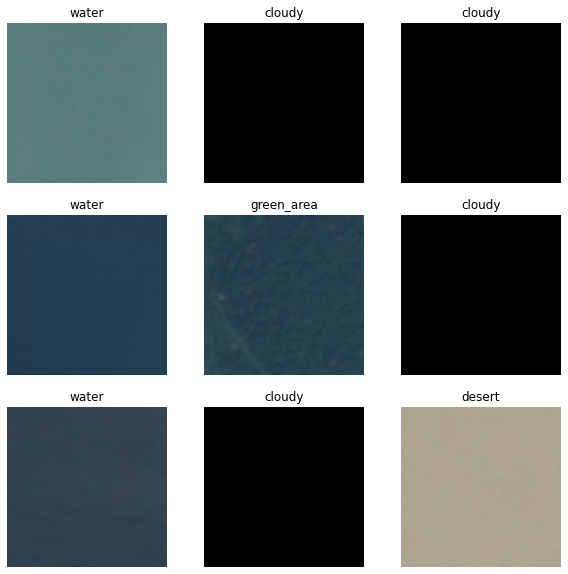

In [5]:
train_dataset = image_dataset_from_directory('../input/satellite-image-classification/data',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [6]:
#call vgg model
vgg_model =  VGG19(include_top=True , weights='imagenet')
for models in vgg_model.layers:
  models.trainable= False

574717952/574710816 [==============================] - 4s 0us/step


In [7]:
#converting from functionally model to sequential model
#removing the last 2 alyer to get rid of output layer in VGG16
vgg_model = keras.Model(inputs=vgg_model.input, outputs=vgg_model.layers[-2].output)
model = keras.Sequential()
for layer in vgg_model.layers:
  model.add(layer)

model.add(Dense(4, activation='softmax'))

In [8]:
model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [9]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [10]:
FIT =model.fit(train_generator,
    validation_data = test_generator, 
    callbacks = [early],
    epochs = 50)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
124/124 [==============================] - 116s 855ms/step - loss: 1.3871 - accuracy: 0.3547 - val_loss: 1.1493 - val_accuracy: 0.4310
Epoch 2/50
124/124 [==============================] - 73s 588ms/step - loss: 0.9653 - accuracy: 0.6095 - val_loss: 0.7726 - val_accuracy: 0.8135
Epoch 3/50
124/124 [==============================] - 72s 581ms/step - loss: 0.7661 - accuracy: 0.7636 - val_loss: 0.7138 - val_accuracy: 0.7620
Epoch 4/50
124/124 [==============================] - 72s 585ms/step - loss: 0.6542 - accuracy: 0.8068 - val_loss: 0.5979 - val_accuracy: 0.8431
Epoch 5/50
124/124 [==============================] - 73s 592ms/step - loss: 0.5771 - accuracy: 0.8486 - val_loss: 0.5920 - val_accuracy: 0.7821
Epoch 6/50
124/124 [==============================] - 75s 606ms/step - loss: 0.5415 - accuracy: 0.8439 - val_loss: 0.5518 - val_accuracy: 0.8111
Epoch 7/50
124/124 [==============================] - 73s 590ms/step - loss: 0.5038 - accuracy: 0.8490 - val_loss: 0.5128 - val_a

In [11]:
model.evaluate(test_generator)

53/53 [==============================] - 22s 413ms/step - loss: 0.2067 - accuracy: 0.9254


[0.20665383338928223, 0.925399661064148]

In [12]:
#classes names 
class_name = {0:"cloud",1:"desert" , 2 : 'green_area', 3: 'water'}


In [13]:
#predict test data
y = model.predict(test_generator)
y =  np.argmax(y,axis= 1 )
y 

array([0, 3, 2, ..., 0, 0, 2])

In [14]:
#y_true and y_pred
y_true = np.array([])
y_pred = np.array([])

i = 0
for data, labels in test_generator:
  i += 1
  y = np.argmax(model.predict(data), axis=1)
  y_true = np.append(y_true, labels)
  y_pred = np.append(y_pred, y)
  
  if i == test_generator.samples // 32 + 1:
    break

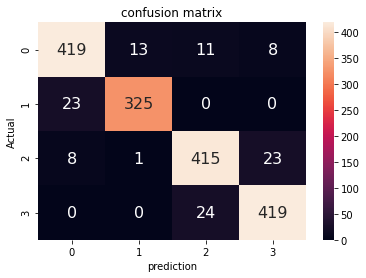

In [15]:
cm  = confusion_matrix(y_pred,y_true)
df_cm = pd.DataFrame(cm, index = [i for i in range(4)],
                  columns = [i for i in range(4)])
seaborn .heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

In [16]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       451
         1.0       0.96      0.93      0.95       348
         2.0       0.92      0.93      0.93       447
         3.0       0.93      0.95      0.94       443

    accuracy                           0.93      1689
   macro avg       0.94      0.93      0.93      1689
weighted avg       0.93      0.93      0.93      1689



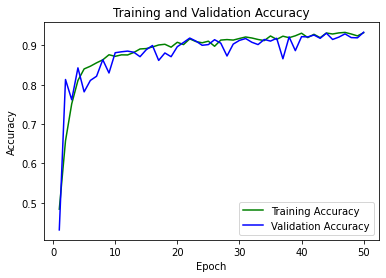

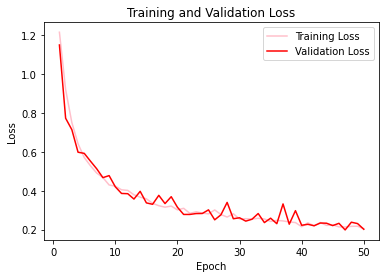

In [17]:
#plot the result
import matplotlib.pyplot as plt
acc = FIT.history['accuracy']
val_acc = FIT.history['val_accuracy']
loss = FIT.history['loss']
val_loss = FIT.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
model.save('vggg19_model.h5')